# Report for Ratings-Results

This report can be used to get an overview on the state of the evaluation.<br/>
It pulls the current ratings from firebase and uses different aggregations in order to create a number of visualizations and statistics.

### Pulling the data

In [1]:
from report import create_report_files
pull_data = True

if pull_data:
    create_report_files(
        "../../keys/gs-on-a-budget-firebase-adminsdk-63ws0-509fffaf5f.json",
        "ratings-v5.xlsx",
        "pairs-v5.xlsx",
    )

### Loading and displaying the raw data

In [2]:
import pandas as pd

pairs = pd.read_excel("./pairs-v5.xlsx")
pairs.columns.values

array(['Unnamed: 0', 'rotation', 'model_2', 'initial_distance', 'fov_y',
       'n_ratings', 'high_detail', 'technique_1', 'model_1',
       'technique_2', 'size', 'dataset_name', 'position', 'dataset',
       'aspect', 'id'], dtype=object)

In [3]:
ratings = pd.read_excel("./ratings-v5.xlsx")
ratings["timestamp"] = ratings["timestamp"].apply(pd.to_datetime)
ratings.columns.values

array(['Unnamed: 0', 'technique_2', 'size', 'rating', 'dataset',
       'user_id', 'pair_id', 'technique_1', 'timestamp', 'id', 'rating_1',
       'rating_2'], dtype=object)

### How many ratings are there per pair?

In [4]:
ratings_count_computed = ratings.groupby("pair_id")["id"].count()
df_ratings_count_computed = pd.DataFrame.from_dict({
    "pair_id": ratings_count_computed.index,
    "count": ratings_count_computed.values
}).sort_values("count", ascending=False)
df_ratings_count_computed

,pair_id,count
26,AXCAW0Sac9plQWEH2pi4,3
85,sGEqUwHWXm4uNV50fIul,3
3,0uSshiYpzXHdIn1okZsk,2
12,3oCaNI7N11UjdwsgwiY6,2
14,4F14IrWf2S6Uwzm7ajl4,2
...,...,...
94,wNmqgdMKte48MR0lSs8V,1
96,wbJENHoedilRBPklpO3w,1
95,wWvmTfL2WqIoehOZiqhS,1
97,x4yFyy0x8GgtgYalqlpa,1


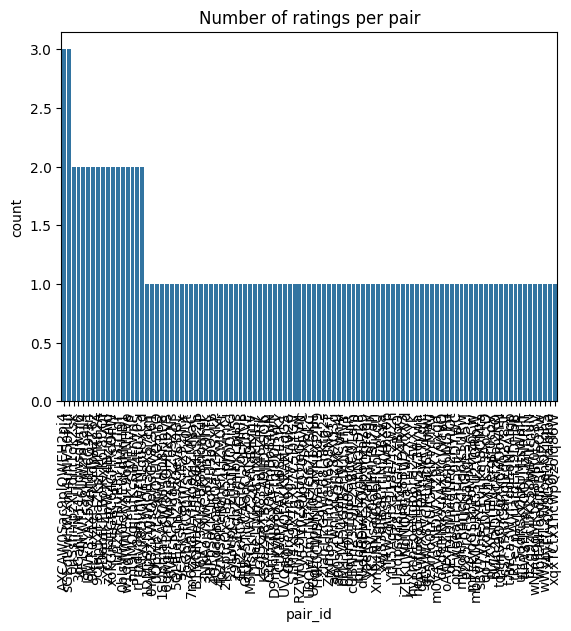

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.barplot(df_ratings_count_computed, x="pair_id", y="count")
plt.xticks(rotation=90)
plt.title("Number of ratings per pair")
plt.show()

In [6]:
# Check what percentage of pairs has been covered once
print(f"{df_ratings_count_computed.shape[0]}/{pairs.shape[0]} pairs have been covered. Thats {round(df_ratings_count_computed.shape[0] / pairs.shape[0] * 100, 2)}%.")

101/189 pairs have been covered. Thats 53.44%.


In [7]:
# sanity check from ratings side if all n_ratings are actually covered by actual ratings
for idx, row in pairs.iterrows():
    if row["n_ratings"] >= 1:
        if id in ratings_count_computed:
            if not (ratings_count_computed[id] == row["n_ratings"]):
                print(f"Error! pair \"{row['id']}\" had different n_ratings than actual rating entities {row['n_ratings']} != {ratings_count_computed[id]}")
        else:
            print(f"Error! pair \"{row['id']}\" had different n_ratings than actual rating entities {row['n_ratings']} != {0}")

Error! pair "0Qbwb7Lis9pOLUVOSIrO" had different n_ratings than actual rating entities 1 != 0
Error! pair "0YwyBZxWsQpHsGv8LS61" had different n_ratings than actual rating entities 1 != 0
Error! pair "0bIsWmiOeRXEyKdMrHB1" had different n_ratings than actual rating entities 2 != 0
Error! pair "0uSshiYpzXHdIn1okZsk" had different n_ratings than actual rating entities 2 != 0
Error! pair "1DMpSYJYgWlOR38X57hm" had different n_ratings than actual rating entities 1 != 0
Error! pair "1SUpmaSAQQNMdD8FibPB" had different n_ratings than actual rating entities 1 != 0
Error! pair "1njZxACnAGt6T5qLMRlL" had different n_ratings than actual rating entities 1 != 0
Error! pair "29sPSf4gbZUmlbkLou5s" had different n_ratings than actual rating entities 1 != 0
Error! pair "2kRptcQx5PSo54pmymCi" had different n_ratings than actual rating entities 1 != 0
Error! pair "2yLwlpCr3EttnrWODivG" had different n_ratings than actual rating entities 1 != 0
Error! pair "3BPbSeLlA1pP4U3oOUfy" had different n_ratings t

In [8]:
# sanity check to see if ratings and n_ratings actually match up
for pair_id, n_ratings in ratings_count_computed.items():
    pair = pairs[pairs["id"] == pair_id]
    if pair.shape[0] != 1:
        print(f'ERROR: pair "{pair_id}" occurs "{pair.shape[0]}" times')
    db_n_ratings = pair["n_ratings"].values[0]
    if n_ratings != db_n_ratings:
        print(
            f'ERROR: pair "{pair_id}" has {n_ratings} but ratings tracker only has {db_n_ratings}'
        )

### How many ratings per user?

In [9]:
ratings_per_user = ratings.groupby("user_id")["id"].count()
df_ratings_per_user = pd.DataFrame.from_dict(
    {"user_id": ratings_per_user.index, "count": ratings_per_user.values}
).sort_values("count", ascending=False)
df_ratings_per_user

,user_id,count
8,d8033277-b91a-4a77-8a57-77b042e1497d,31
0,0a665c40-da19-49db-ad71-f87e7af9c0d8,23
2,3b6c78e7-b0e6-4c75-a3f3-e1dccc7c9361,14
4,4dc54225-0f2f-40ce-8ed5-1b18cb929d29,12
7,a7037b14-2e6d-4f7d-bac8-ed02d7df5329,6
3,450cd38d-27d8-4b1e-b397-f6aa0769f389,6
11,e5de31f2-fc40-4062-9135-3aba73149106,5
10,e2e13763-bad1-40d3-9c2c-52c7e9d12d9f,5
9,e02cbd32-23a2-4b8e-b47f-f94d9ff7f400,5
1,19b57dbb-8b65-48f2-a217-3287973988cd,4


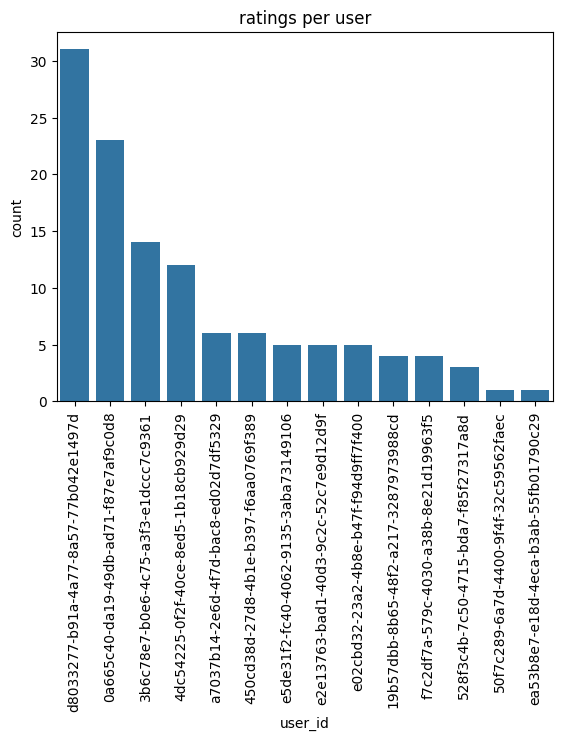

In [10]:
sns.barplot(df_ratings_per_user, x="user_id", y="count")
plt.xticks(rotation=90)
plt.title("ratings per user")
plt.show()

### How many times has every individual model been rated?

In [11]:
rating_records = []

for idx, row in ratings.iterrows():
    pair = pairs[row["pair_id"] == pairs["id"]].iloc[0]
    rating_records.append(
        {
            "model_name": str(pair["model_1"])
            .replace("splats/", "")
            .replace(".ksplat", ""),
            "preferred": row["rating"] == "first",
            "user_id": row["user_id"],
        }
    )
    rating_records.append(
        {
            "model_name": str(pair["model_2"])
            .replace("splats/", "")
            .replace(".ksplat", ""),
            "preferred": row["rating"] == "second",
            "user_id": row["user_id"],
        }
    )

df_ratings_per_model = pd.DataFrame.from_records(rating_records)
df_ratings_per_model

,model_name,preferred,user_id
0,eagles-truck-medium-1,True,d8033277-b91a-4a77-8a57-77b042e1497d
1,geo_gaussian-truck-medium-1,False,d8033277-b91a-4a77-8a57-77b042e1497d
2,default-truck-low-1,True,4dc54225-0f2f-40ce-8ed5-1b18cb929d29
3,eagles-truck-low-1,False,4dc54225-0f2f-40ce-8ed5-1b18cb929d29
4,mini_splatting-stump-medium-1,True,528f3c4b-7c50-4715-bda7-f85f27317a8d
...,...,...,...
235,geo_gaussian-stump-low-1,False,d8033277-b91a-4a77-8a57-77b042e1497d
236,eagles-room-high-1,True,3b6c78e7-b0e6-4c75-a3f3-e1dccc7c9361
237,mip_splatting-room-high-1,False,3b6c78e7-b0e6-4c75-a3f3-e1dccc7c9361
238,eagles-stump-high-1,True,e2e13763-bad1-40d3-9c2c-52c7e9d12d9f


In [12]:
count_ratings_per_model = df_ratings_per_model.groupby("model_name")["model_name"].count()
df_count_ratings_per_model = pd.DataFrame.from_dict({
    "model_name": count_ratings_per_model.index,
    "n_ratings": count_ratings_per_model.values,
}).sort_values("n_ratings", ascending=False)
df_count_ratings_per_model

,model_name,n_ratings
4,default-stump-low-1,8
30,geo_gaussian-stump-low-1,8
19,gaussian_pro-room-medium-1,7
16,eagles-truck-medium-1,7
25,gaussian_pro-truck-medium-1,7
...,...,...
33,geo_gaussian-truck-low-1,1
41,mcmc-truck-high-1,1
50,mini_splatting-truck-high-1,1
51,mini_splatting-truck-low-1,1


### Whats the just objectionable difference (JOD) for each dataset/approach/size?

In [13]:
from typing import NamedTuple
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
from matplotlib import pyplot as plt


index = {
    "default": 0,
    "mcmc": 1,
    "mini_splatting": 2,
    "eagles": 3,
    "mip_splatting": 4,
    "gaussian_pro": 5,
    "geo_gaussian": 6,
}


def create_preference_matrix_from_df(df: pd.DataFrame) -> np.ndarray:
    preferences = np.zeros((7, 7), dtype=np.uint)

    for _, rating in df.iterrows():
        if rating["rating"] == "first":
            preferences[index[rating["technique_1"]]][index[rating["technique_2"]]] = (
                preferences[index[rating["technique_1"]]][index[rating["technique_2"]]]
                + 1
            )
        if rating["rating"] == "second":
            preferences[index[rating["technique_2"]]][index[rating["technique_1"]]] = (
                preferences[index[rating["technique_2"]]][index[rating["technique_1"]]]
                + 1
            )

    return preferences


# Function to calculate log-likelihood
def thurstone_log_likelihood(mu: np.ndarray, C: np.ndarray) -> float:
    n = len(mu)
    log_likelihood = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                p_ij = norm.cdf((mu[i] - mu[j]) / np.sqrt(2))
                log_likelihood += C[i, j] * np.log(
                    p_ij + 1e-9
                )  # Add a small value to avoid log(0)
    return -log_likelihood


class JodResults(NamedTuple):
    default: float
    mcmc: float
    mini_splatting: float
    eagles: float
    mip_splatting: float
    gaussian_pro: float
    geo_gaussian: float

    def to_array(self) -> np.ndarray:
        return np.array(
            [
                self.default,
                self.mcmc,
                self.mini_splatting,
                self.eagles,
                self.mip_splatting,
                self.gaussian_pro,
                self.geo_gaussian,
            ]
        )


def compute_jod(preferences: np.ndarray) -> JodResults:
    # Initial guess for latent qualities
    n_stimuli = preferences.shape[0]
    mu_init = np.zeros(n_stimuli)

    # Optimize latent scores
    result = minimize(
        thurstone_log_likelihood, mu_init, args=(preferences,), method="BFGS"
    )
    [
        default,
        mcmc,
        mini_splatting,
        eagles,
        mip_splatting,
        gaussian_pro,
        geo_gaussian,
    ] = result.x

    return JodResults(
        default,
        mcmc,
        mini_splatting,
        eagles,
        mip_splatting,
        gaussian_pro,
        geo_gaussian,
    )


def plot_jod_full() -> pd.DataFrame:
    _, axs = plt.subplots(3, 3, sharex=True, sharey=True)

    records = []

    for i, size in enumerate(["low", "medium", "high"]):
        for j, dataset in enumerate(["room", "stump", "truck"]):
            current_ratings = ratings[
                (ratings["size"] == size) & (ratings["dataset"] == dataset)
            ]
            preferences = create_preference_matrix_from_df(current_ratings)
            jod_results = compute_jod(preferences)

            axs[i][j].bar(index.keys(), jod_results.to_array())
            if i == 2:
                axs[i][j].tick_params(labelrotation=90)
                plt.setp(axs[-1, j], xlabel=dataset)
            else:
                axs[i][j].set_xticks(["" for _ in range(7)])

            if j == 0:
                plt.setp(axs[i, 0], ylabel=size)

            records.append(
                {
                    "size": size,
                    "dataset": dataset,
                    "default": jod_results.default,
                    "mcmc": jod_results.mcmc,
                    "mini_splatting": jod_results.mini_splatting,
                    "eagles": jod_results.eagles,
                    "mip_splatting": jod_results.mip_splatting,
                    "gaussian_pro": jod_results.gaussian_pro,
                    "geo_gaussian": jod_results.geo_gaussian,
                }
            )

    plt.tight_layout()
    plt.show()

    return pd.DataFrame.from_records(records)

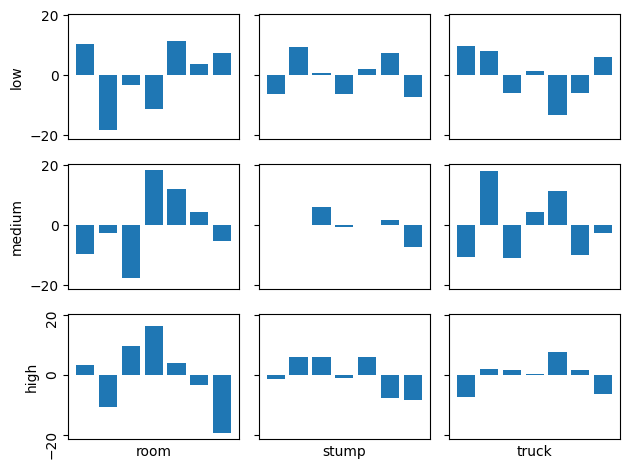

In [14]:
df_jod_full = plot_jod_full()

In [22]:
def compute_jod_batched(batch_size: int) -> pd.DataFrame:
    records = []

    for i, size in enumerate(["low", "medium", "high"]):
        for j, dataset in enumerate(["room", "stump", "truck"]):
            current_ratings = ratings[
                (ratings["size"] == size) & (ratings["dataset"] == dataset)
            ].sort_values("timestamp", na_position="first")

            batches = [current_ratings[pd.isna(current_ratings["timestamp"])]]

            len_na = pd.isna(current_ratings["timestamp"]).sum()
            len_non_na = pd.notna(current_ratings["timestamp"]).sum()
            for i in range(0, len_non_na, batch_size):
                batches.append(
                    current_ratings.iloc[
                        0:(len_na + min(len_non_na, i + batch_size))
                    ]
                )

            for batch_idx, batch in enumerate(batches):
                preferences = create_preference_matrix_from_df(batch)
                jod_results = compute_jod(preferences)

                records.append(
                    {
                        "size": size,
                        "dataset": dataset,
                        "batch_idx": batch_idx,
                        "default": jod_results.default,
                        "mcmc": jod_results.mcmc,
                        "mini_splatting": jod_results.mini_splatting,
                        "eagles": jod_results.eagles,
                        "mip_splatting": jod_results.mip_splatting,
                        "gaussian_pro": jod_results.gaussian_pro,
                        "geo_gaussian": jod_results.geo_gaussian,
                    }
                )

    return pd.DataFrame.from_records(records)

In [23]:
df_jod_batched_10 = compute_jod_batched(10)


In [24]:
df_jod_batched_5 = compute_jod_batched(5)

In [ ]:
df_jod_batched_3 = compute_jod_batched(3)

In [ ]:
df_jod_batched_20 = compute_jod_batched(20)

In [17]:
def plot_jod_batched(df_batched: pd.DataFrame) -> None:
    _, axs = plt.subplots(3, 3, sharex=True, sharey=True)
    lines = []
    columns = ["default", "mcmc","mini_splatting",	"eagles", "mip_splatting", "gaussian_pro", "geo_gaussian"]
    for i, size in enumerate(["low", "medium", "high"]):
        for j, dataset in enumerate(["room", "stump", "truck"]):
            current = df_batched[
                (df_batched["size"] == size) & (df_batched["dataset"] == dataset)
            ]
            for col in columns:
                line, = axs[i][j].plot(current["batch_idx"], current[col])
                if i == 0 and j == 0:
                    lines.append(line)
            
            if i == 2:
                axs[i][j].tick_params(labelrotation=90)
                plt.setp(axs[-1, j], xlabel=dataset)
            else:
                pass
                # axs[i][j].set_xticks(["" for _ in range(len(current))])

            if j == 0:
                plt.setp(axs[i, 0], ylabel=size)

    plt.tight_layout()
    axs[1, 2].legend(lines, columns, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

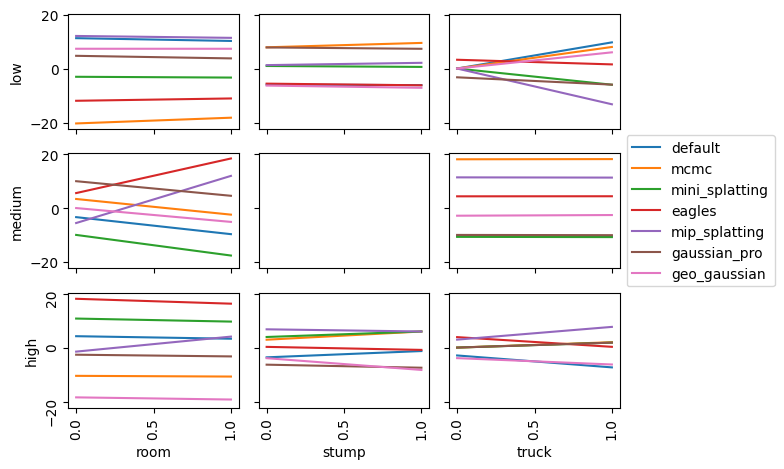

In [ ]:
plot_jod_batched(df_jod_batched_10)

In [ ]:
plot_jod_batched(df_jod_batched_3)

In [ ]:
plot_jod_batched(df_jod_batched_5)

In [ ]:
plot_jod_batched(df_jod_batched_20)

In [19]:
df_jod_batched

,size,dataset,batch_idx,default,mcmc,mini_splatting,eagles,mip_splatting,gaussian_pro,geo_gaussian
0,low,room,0,11.247527,-20.345374,-3.057703,-11.949081,12.068973,4.710115,7.325541
1,low,room,1,10.217731,-18.218717,-3.351004,-11.087745,11.365275,3.755708,7.318749
2,low,stump,0,-5.960556,7.865515,0.940043,-5.600587,1.261902,7.814204,-6.320528
3,low,stump,1,-6.153883,9.488162,0.599300,-6.213852,2.113021,7.309186,-7.141941
4,low,truck,0,0.000000,0.000000,0.000000,3.252158,0.000000,-3.252158,0.000000
5,low,truck,1,9.691204,7.987902,-6.001096,1.531988,-13.245580,-5.965513,6.001095
6,medium,room,0,-3.361905,3.361904,-9.951349,5.548224,-5.548225,9.951349,0.000000
7,medium,room,1,-9.671394,-2.437136,-17.590815,18.369011,11.916819,4.545567,-5.132050
8,medium,stump,0,0.000000,0.000000,6.020602,-0.667038,0.000000,1.763366,-7.116931
9,medium,truck,0,-10.316033,18.066488,-10.676006,4.346154,11.371495,-9.956064,-2.836037


In [20]:
df_ratings_per_model["model"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[0]
)
df_ratings_per_model["dataset"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[1]
)
df_ratings_per_model["size"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[2]
)
df_ratings_per_model
# df_grouped["n_splats"] = df_grouped["size"].apply(
#     lambda size: {
#         "low": 117856,
#         "medium": 412235,
#         "high": 1093135,
#         "extended": 2186270,
#     }[size]
# )
# df_grouped

,model_name,preferred,user_id,model,dataset,size
0,eagles-truck-medium-1,True,d8033277-b91a-4a77-8a57-77b042e1497d,eagles,truck,medium
1,geo_gaussian-truck-medium-1,False,d8033277-b91a-4a77-8a57-77b042e1497d,geo_gaussian,truck,medium
2,default-truck-low-1,True,4dc54225-0f2f-40ce-8ed5-1b18cb929d29,default,truck,low
3,eagles-truck-low-1,False,4dc54225-0f2f-40ce-8ed5-1b18cb929d29,eagles,truck,low
4,mini_splatting-stump-medium-1,True,528f3c4b-7c50-4715-bda7-f85f27317a8d,mini_splatting,stump,medium
...,...,...,...,...,...,...
235,geo_gaussian-stump-low-1,False,d8033277-b91a-4a77-8a57-77b042e1497d,geo_gaussian,stump,low
236,eagles-room-high-1,True,3b6c78e7-b0e6-4c75-a3f3-e1dccc7c9361,eagles,room,high
237,mip_splatting-room-high-1,False,3b6c78e7-b0e6-4c75-a3f3-e1dccc7c9361,mip_splatting,room,high
238,eagles-stump-high-1,True,e2e13763-bad1-40d3-9c2c-52c7e9d12d9f,eagles,stump,high


NameError: name 'df_grouped' is not defined

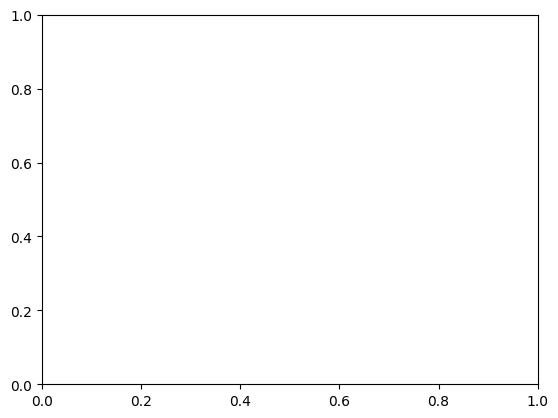

In [21]:
ax = plt.subplot()
sns.lineplot(df_grouped, x="n_splats", y="rating", hue="model", ax=ax)
plt.title("MOS per splat budget (Truck dataset)")
ax.set_xticks([117856, 412235, 1093135, 2186270], ["low", "medium", "high", "extended"])
plt.show()

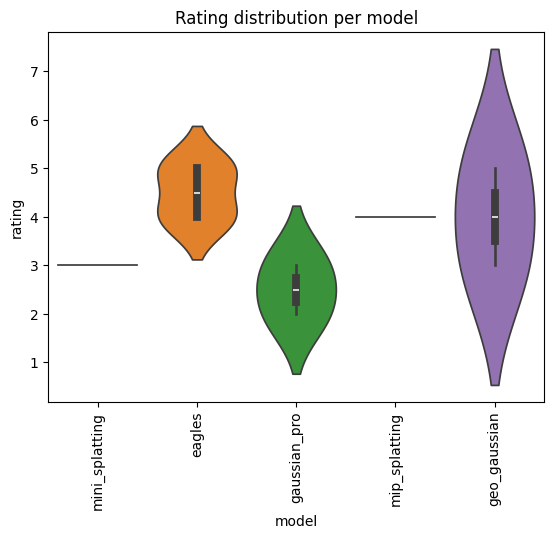

In [96]:
sns.violinplot(df_ratings_truck, x="model", y="rating", hue="model")
plt.title("Rating distribution per model")
plt.xticks(rotation=90)
plt.show()